# Mice Protein Gene Expression

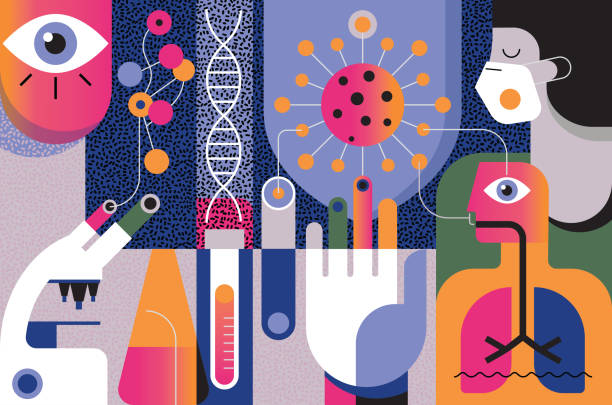

In [71]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from scipy.cluster.hierarchy import linkage, fcluster
from scipy.cluster.hierarchy import dendrogram
from scipy.stats import f_oneway


## Cleaning the Dataset

In [18]:
mice1 = '../cortical_protein_expression//mice_gene_dataset/Data_Cortex_Nuclear.csv'
mice2 = '../cortical_protein_expression//mice_gene_dataset/Data_Cortex_Nuclear2.csv'

# List of input CSV file names
input_mice = [mice1, mice2]

# Read each CSV file into a DataFrame
dfs_mice = [pd.read_csv(file) for file in input_mice]

# Concatenate the DataFrames
concat_mice = pd.concat(dfs_mice)


In [13]:
concat_mice.isnull().sum().sort_values(ascending = False).head(10)


BCL2_N        570
H3MeK4_N      540
BAD_N         426
EGR1_N        420
H3AcK18_N     360
pCFOS_N       150
ELK_N          36
Bcatenin_N     36
MEK_N          14
P38_N           6
dtype: int64

In [14]:
concat_mice.head()


,MouseID,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
0,309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,...,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
1,309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,...,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
2,309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,...,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
3,309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,...,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
4,309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,...,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,Control,Memantine,C/S,c-CS-m


In [19]:
# Identify columns with more than 75 missing values
nmice = concat_mice.dropna(axis = 1, thresh = len(concat_mice) - 75)
nmice = nmice.dropna(axis = 0)


In [20]:
subset_cols = nmice.loc[:, 'DYRK1A_N':'CaNA_N']
class_col = nmice['class']

# Group by 'class' and sum the values
subset_cols.groupby(class_col).mean()


,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,P3525_N,pCASP9_N,PSD95_N,SNCA_N,Ubiquitin_N,pGSK3B_Tyr216_N,SHH_N,pS6_N,SYP_N,CaNA_N
class,,,,,,,,,,,,,,,,,,,,,
c-CS-m,0.480456,0.652587,0.339217,2.381749,4.308540,0.229932,0.182211,2.916187,0.198484,1.492318,...,0.298304,1.523643,2.141426,0.152442,1.177900,0.866693,0.226911,0.119782,0.467403,1.523659
c-CS-s,0.613559,0.790434,0.342316,2.417971,4.315746,0.219666,0.173684,2.966158,0.209055,1.717638,...,0.284027,1.533783,2.071600,0.146604,1.070902,0.844144,0.211771,0.111999,0.445841,1.635900
c-SC-m,0.273203,0.436361,0.290946,2.145633,3.459416,0.241253,0.189547,4.736327,0.208149,1.278566,...,0.277210,1.638506,2.347967,0.177103,1.403618,0.825483,0.224470,0.128108,0.456874,1.009957
c-SC-s,0.276882,0.455166,0.307163,2.413561,3.839742,0.232721,0.185501,3.124186,0.216793,1.363064,...,0.287231,1.546037,2.378148,0.174709,1.265724,0.802973,0.242129,0.133092,0.466560,1.153488
t-CS-m,0.619294,0.797007,0.312732,2.196541,3.565960,0.213621,0.173956,3.121801,0.203395,1.563905,...,0.279923,1.458555,2.218521,0.138106,1.086861,0.881975,0.216934,0.108196,0.413597,1.633341
t-CS-s,0.525735,0.759556,0.305460,2.184606,3.514839,0.214466,0.164795,2.488902,0.210041,1.518302,...,0.299631,1.491736,2.162338,0.153577,1.193752,0.839139,0.222144,0.111354,0.433587,1.552633
t-SC-m,0.329861,0.566783,0.321063,2.379446,4.056223,0.269131,0.201007,4.277257,0.231789,1.381516,...,0.285037,1.674924,2.377323,0.177276,1.415991,0.834239,0.230667,0.137287,0.445738,1.041134
t-SC-s,0.337488,0.549056,0.325586,2.248742,3.565093,0.246759,0.185318,4.176555,0.227165,1.204840,...,0.314150,1.540418,2.182826,0.157634,1.279150,0.878875,0.235643,0.119205,0.428424,1.224570


## Exploration of Variation in Gene Data

#### Analyzing the clustering behavior of protein expression for each experimental condition

In [21]:
sections = {}

for i, condition in enumerate(nmice['class'].unique()):
    sections[i] = nmice[nmice['class'] == condition]
    

In [22]:
for i in range(len(nmice['class'].unique())):
    print('Condition', i+1, '=', sections[i].iloc[:, 75].head(1))


Condition 1 = 0    c-CS-m
Name: class, dtype: object
Condition 2 = 150    c-SC-m
Name: class, dtype: object
Condition 3 = 300    c-CS-s
Name: class, dtype: object
Condition 4 = 435    c-SC-s
Name: class, dtype: object
Condition 5 = 570    t-CS-m
Name: class, dtype: object
Condition 6 = 705    t-SC-m
Name: class, dtype: object
Condition 7 = 840    t-CS-s
Name: class, dtype: object
Condition 8 = 945    t-SC-s
Name: class, dtype: object


In [23]:
features = {}
classes = {}

for i in range(len(nmice['class'].unique())):
    features[i] = sections[i].loc[:, 'DYRK1A_N':'CaNA_N']
    classes[i] = sections[i]['class']


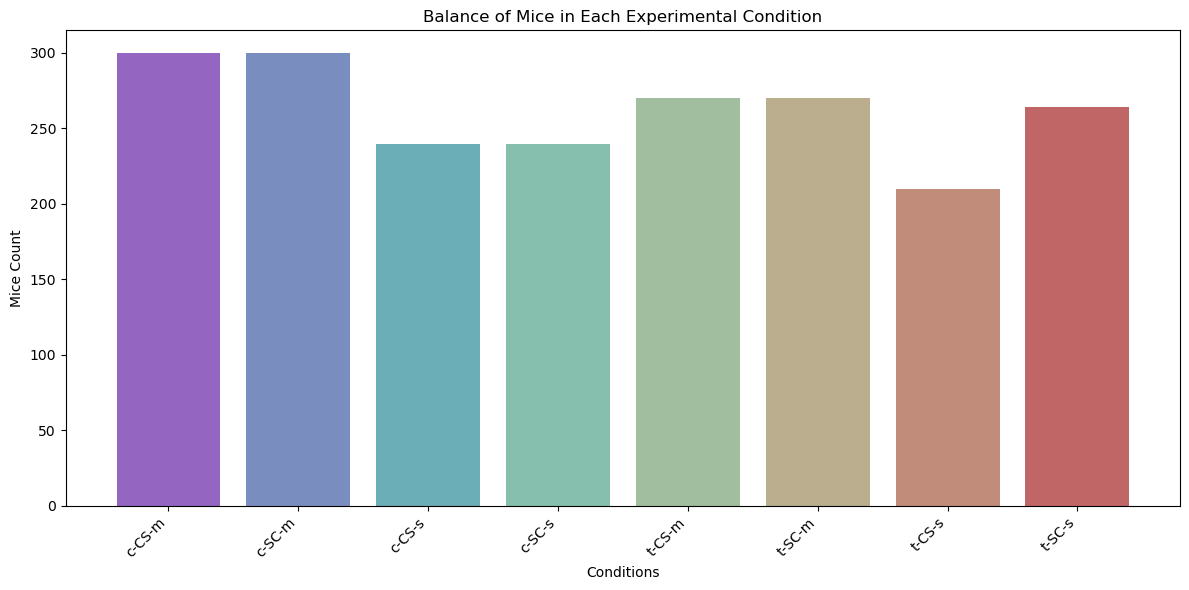

In [24]:
num_rows = []
section_indices = []

for i in range(len(sections)):
    num_rows.append(sections[i].shape[0])
    section_indices.append(classes[i].unique()[0])
    
# Define a colormap
colors = plt.cm.rainbow(np.linspace(0, 1, len(section_indices)))
lighter_colors = colors * 0.6

plt.figure(figsize=(12, 6))
bars = plt.bar(section_indices, num_rows, color=lighter_colors)

plt.xlabel('Conditions')
plt.ylabel('Mice Count')
plt.title('Balance of Mice in Each Experimental Condition')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Creating Hierarchical Clustering Links

In [25]:
def hierarchical_clustering(data, threshold):
    
    # Compute linkage matrix
    Z = linkage(data, method='ward')
    
    # Perform clustering based on the threshold
    cluster_assignments = fcluster(Z, threshold, criterion='distance')
    
    return Z, cluster_assignments


In [26]:
# Extract features from your dataset
X_imp = features[0]

# Define threshold for hierarchical clustering
threshold = 0.5

# Perform hierarchical clustering
Z, cluster_assignments = hierarchical_clustering(X_imp, threshold)


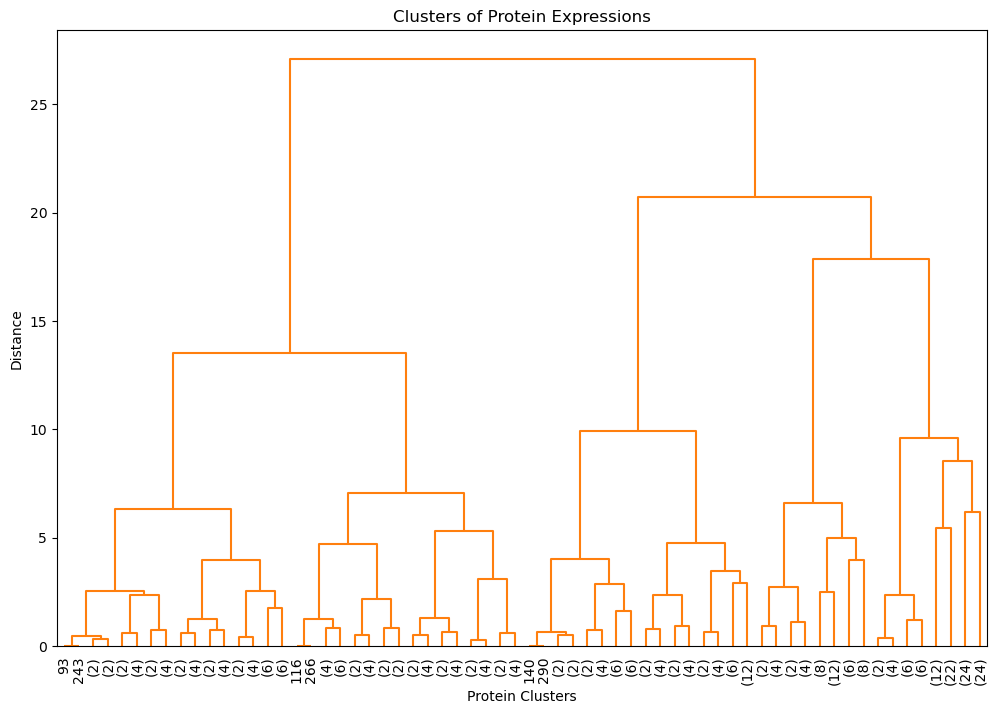

In [28]:
# Visualize the dendrogram with adjusted parameters
plt.figure(figsize=(12, 8))
dendrogram(Z, p = 5, truncate_mode = 'level', orientation='top', color_threshold=50, leaf_font_size=10)

plt.title('Clusters of Protein Expressions')
plt.xlabel('Protein Clusters')
plt.ylabel('Distance')
plt.grid(False)
plt.show()


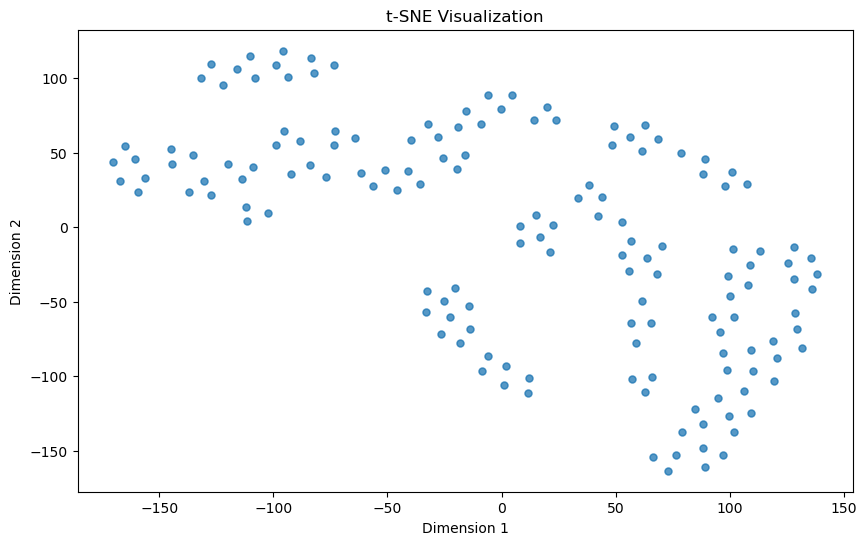

In [29]:
# Apply t-SNE to reduce the dimensionality to two dimensions
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(X_imp)

# Visualize the t-SNE embeddings
plt.figure(figsize=(10, 6))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], s=25, alpha=0.5)
plt.title('t-SNE Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


In [30]:
# making a heatmap of the correlation between each protein expression

def plot_corr(df):
    corr = df.corr()
    _, ax = plt.subplots(figsize = (50, 25))
    cmap = sns.diverging_palette(240, 10, as_cmap=True)
    sns.heatmap(corr, cmap=cmap, square=True, cbar_kws={'shrink': .9}, ax=ax, annot=False)


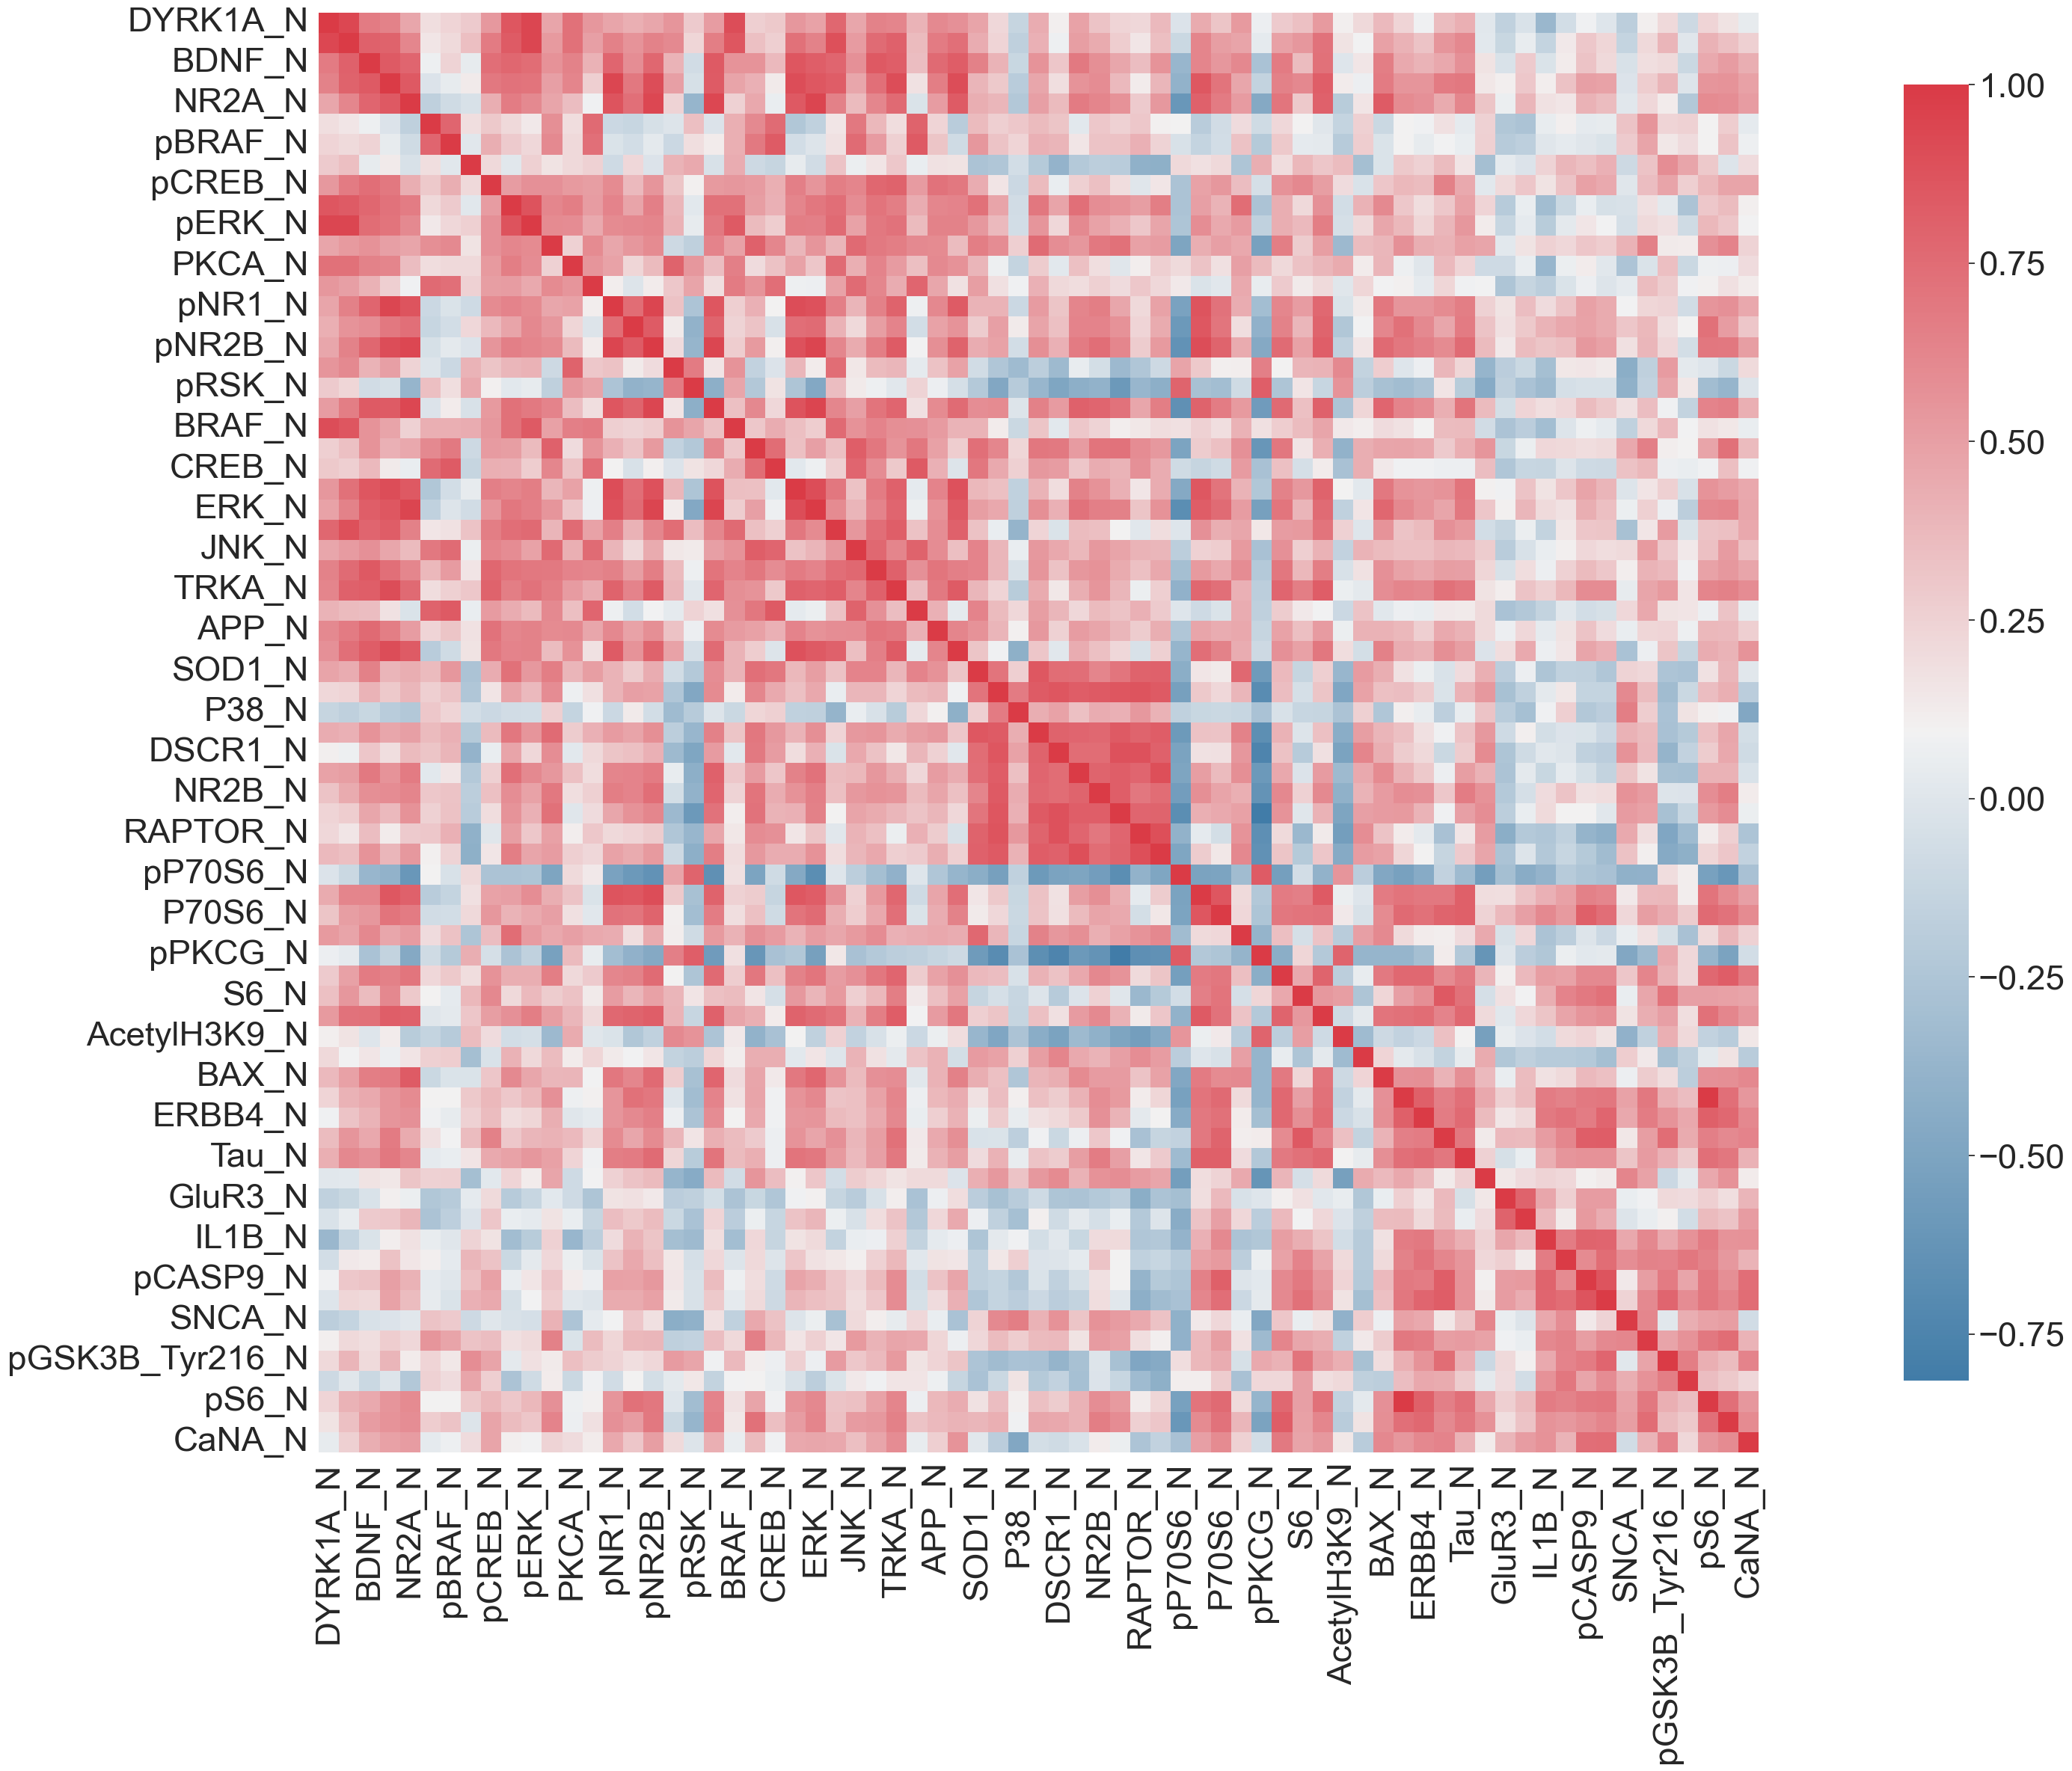

In [31]:
sns.set(font_scale = 3)
plot_corr(X_imp)


In [32]:
# Extract features from your dataset
X_imp_1 = features[1]

# Define threshold for hierarchical clustering
threshold = 0.5

# Perform hierarchical clustering
Z_1, cluster_assignments_1 = hierarchical_clustering(X_imp_1, threshold)


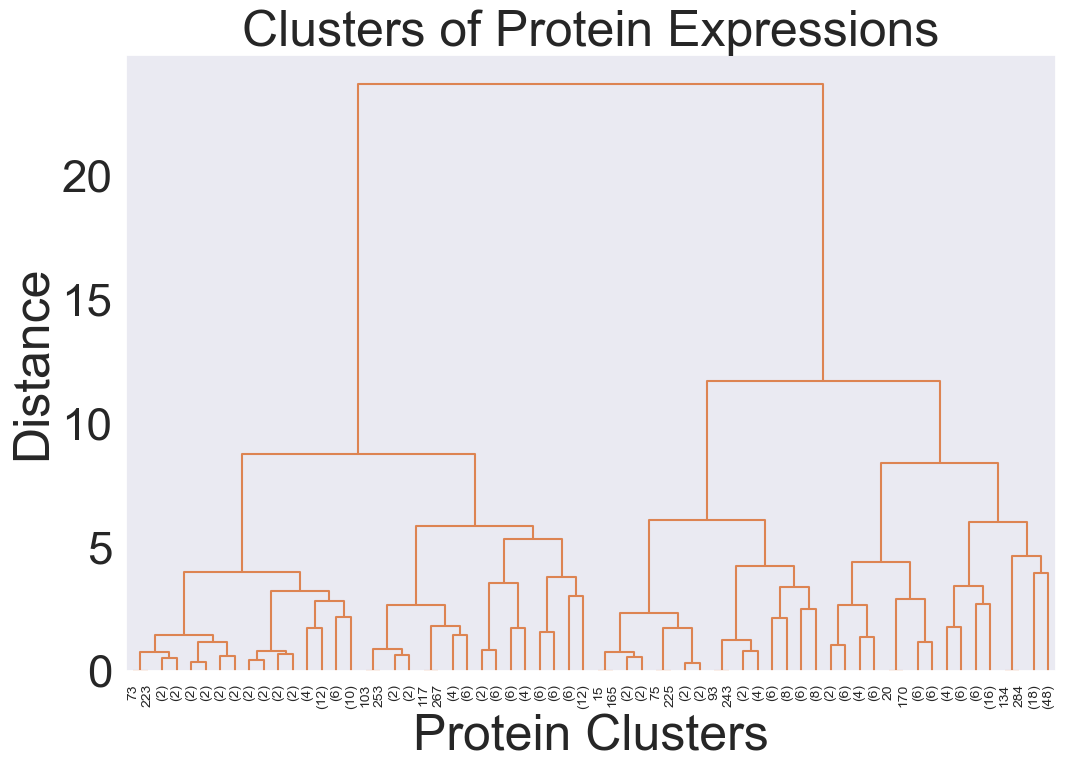

In [33]:
# Visualize the dendrogram with adjusted parameters
plt.figure(figsize=(12, 8))
dendrogram(Z_1, p = 5, truncate_mode = 'level', orientation='top', color_threshold=50, leaf_font_size=10)

plt.title('Clusters of Protein Expressions')
plt.xlabel('Protein Clusters')
plt.ylabel('Distance')
plt.grid(False)
plt.show()


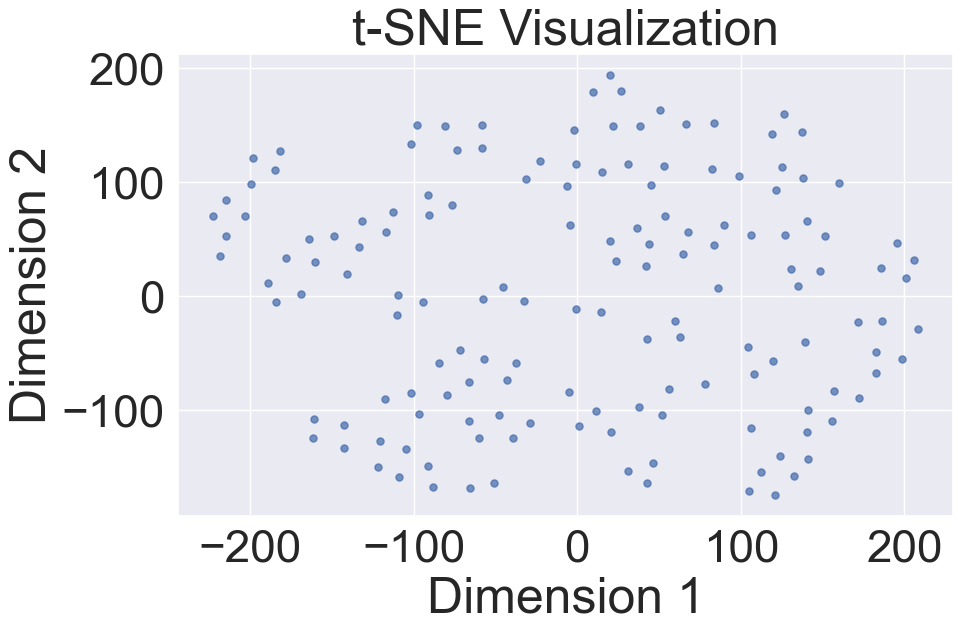

In [34]:
# Apply t-SNE to reduce the dimensionality to two dimensions
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings_1 = tsne.fit_transform(X_imp_1)

# Visualize the t-SNE embeddings
plt.figure(figsize=(10, 6))
plt.scatter(tsne_embeddings_1[:, 0], tsne_embeddings_1[:, 1], s=25, alpha=0.5)
plt.title('t-SNE Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


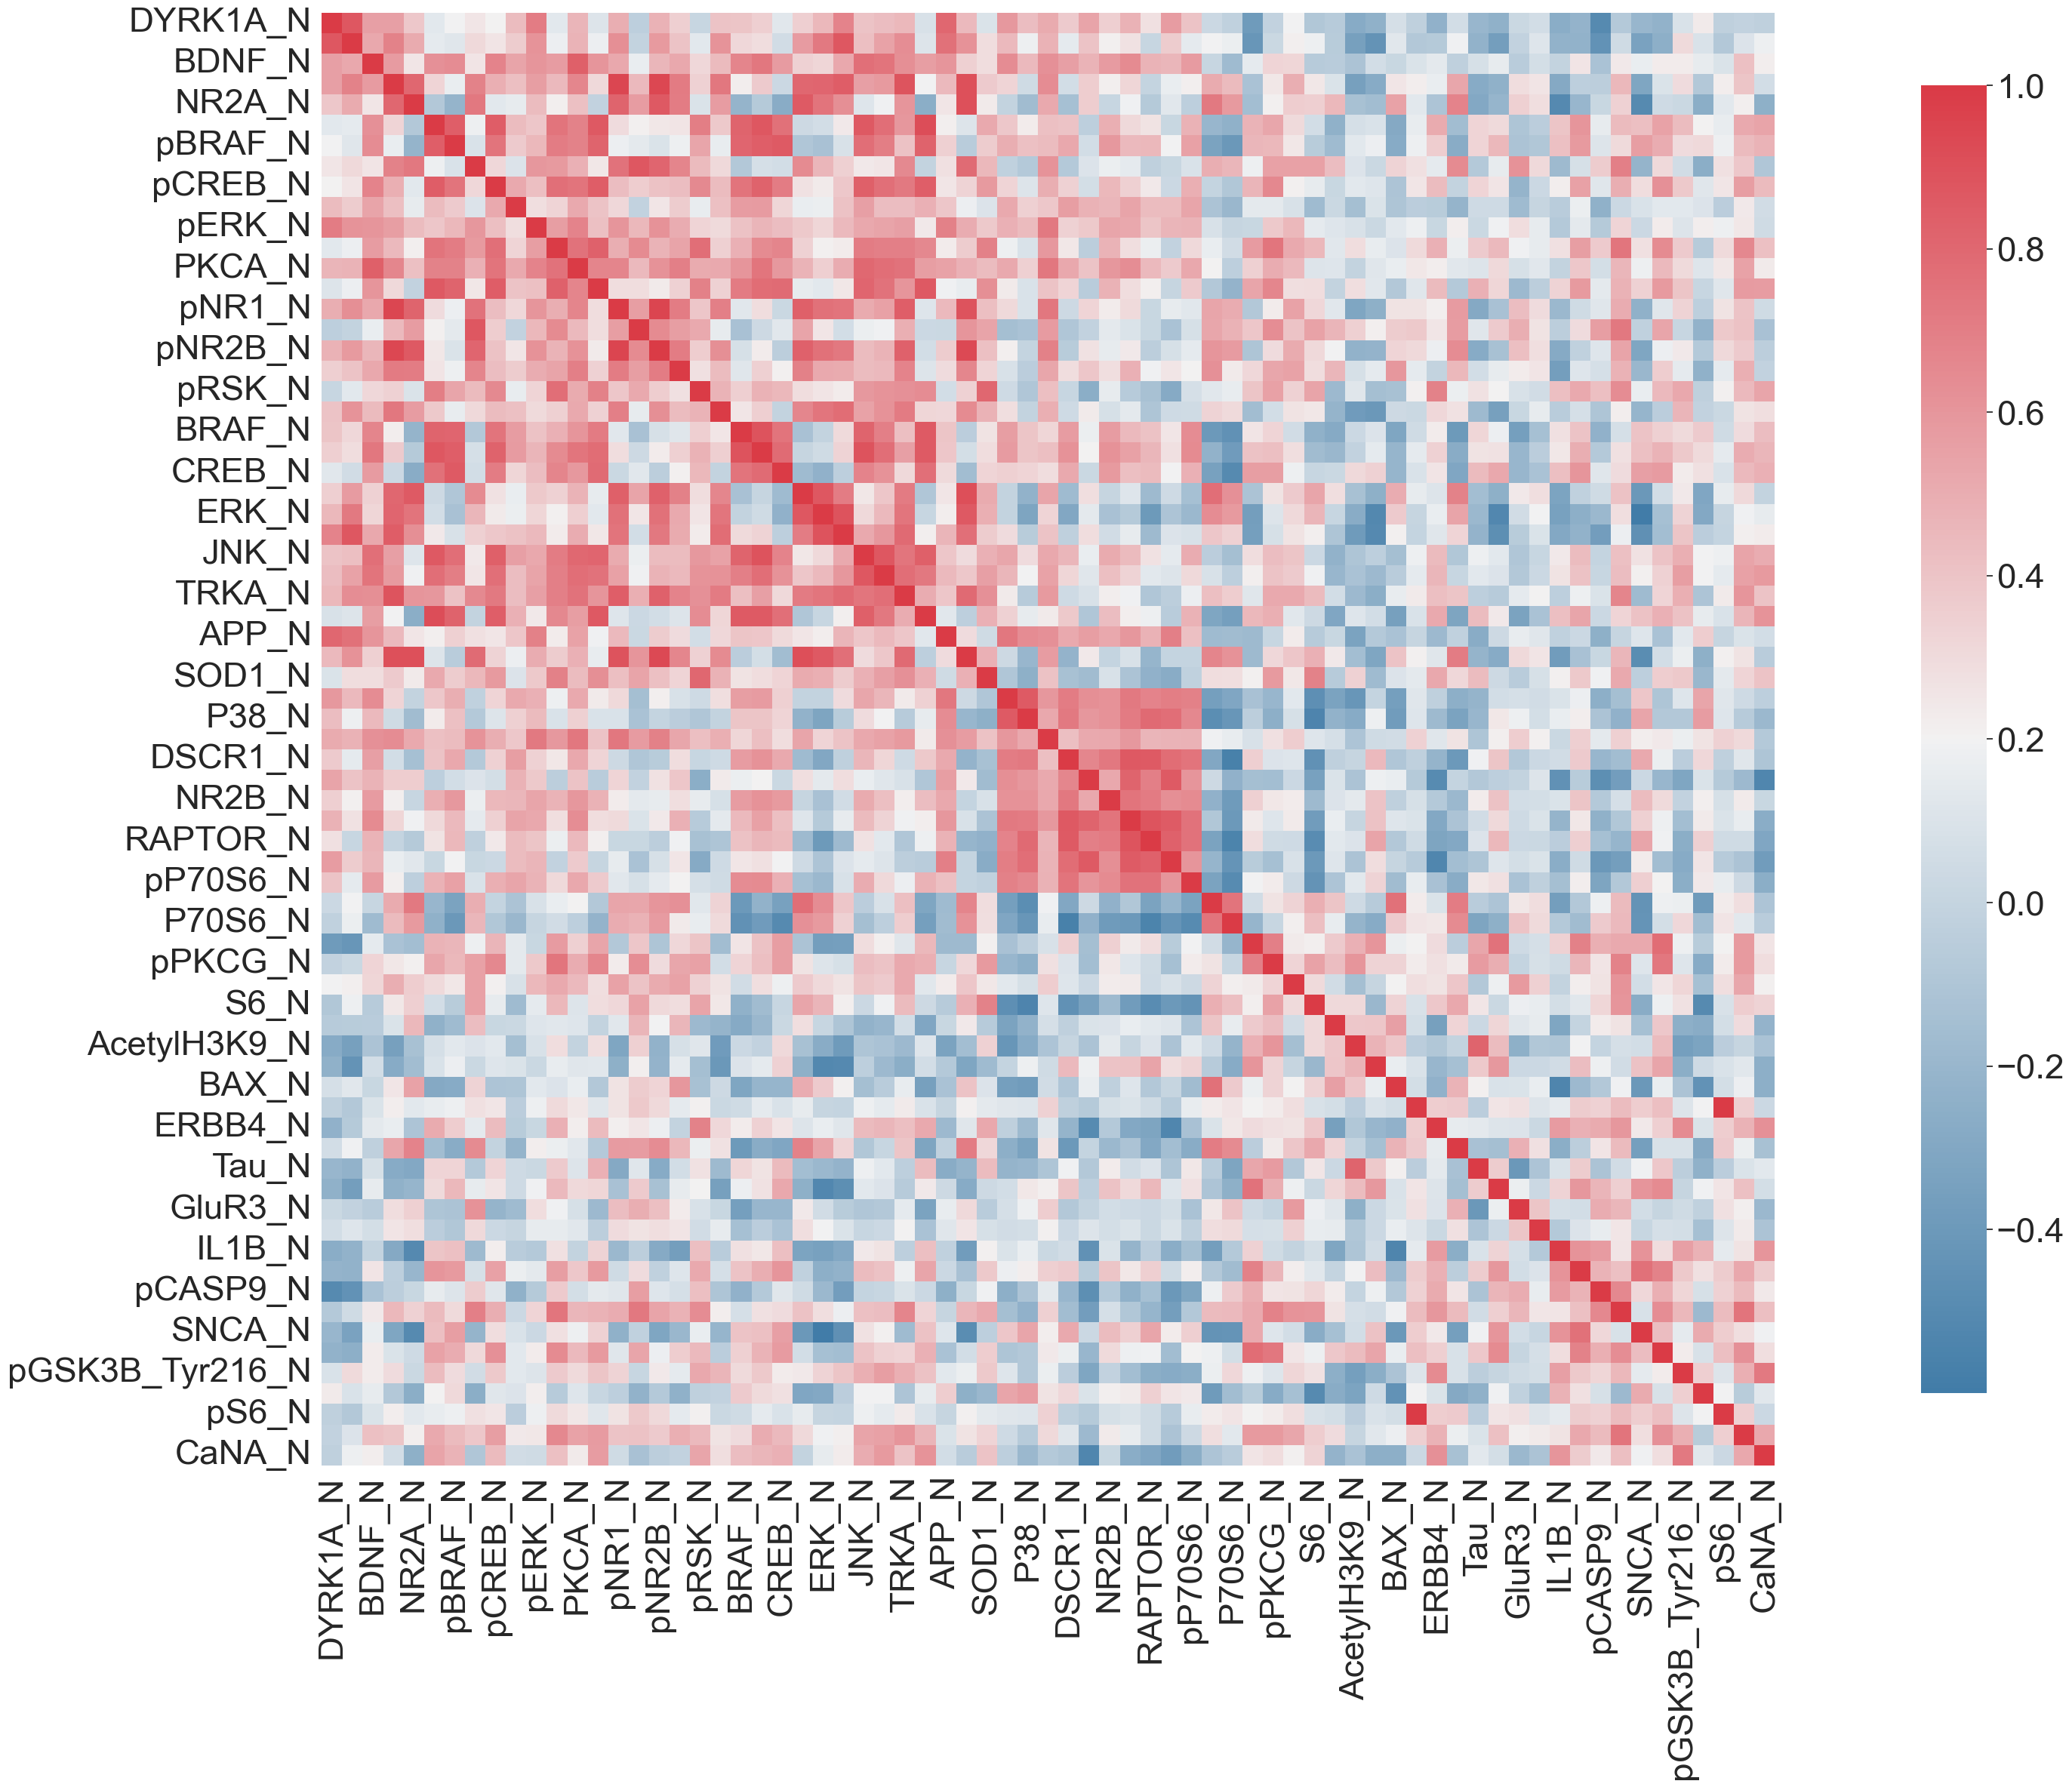

In [35]:
sns.set(font_scale = 3)   
plot_corr(X_imp_1)


In [36]:
# Extract features from your dataset
X_imp_2 = features[2]

# Define threshold for hierarchical clustering
threshold = 0.5

# Perform hierarchical clustering
Z_2, cluster_assignments_2 = hierarchical_clustering(X_imp_2, threshold)


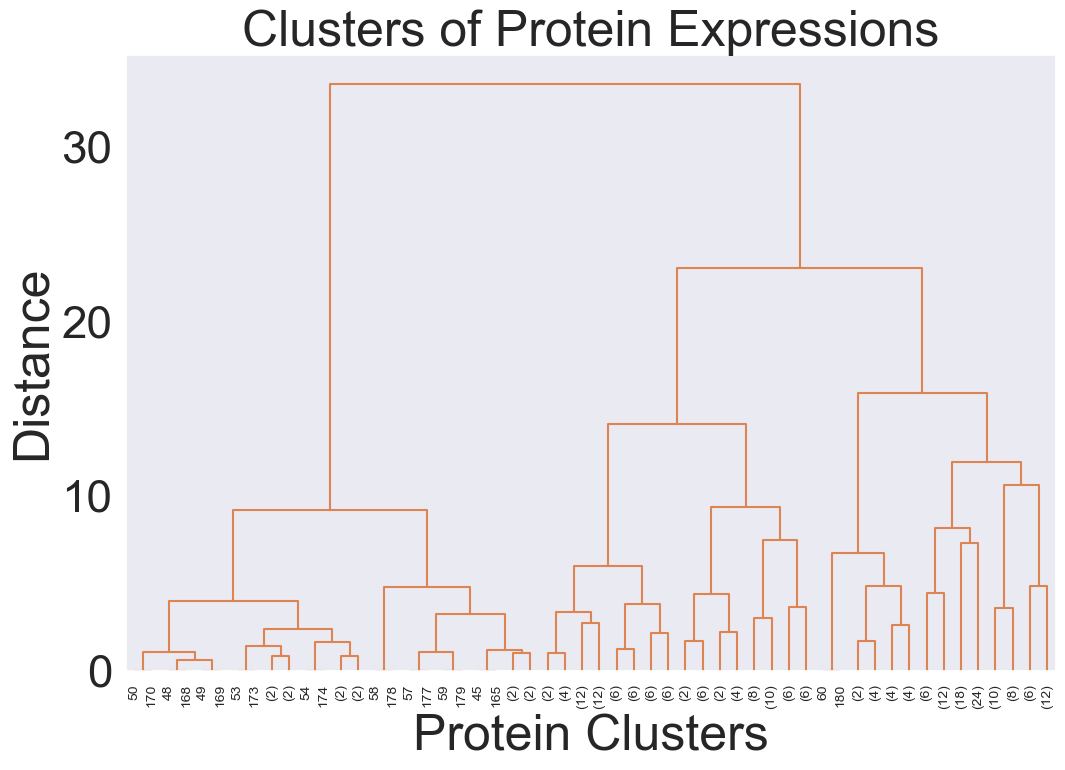

In [37]:
# Visualize the dendrogram with adjusted parameters
plt.figure(figsize=(12, 8))
dendrogram(Z_2, p = 5, truncate_mode = 'level', orientation='top', color_threshold=50, leaf_font_size=10)

plt.title('Clusters of Protein Expressions')
plt.xlabel('Protein Clusters')
plt.ylabel('Distance')
plt.grid(False)
plt.show()


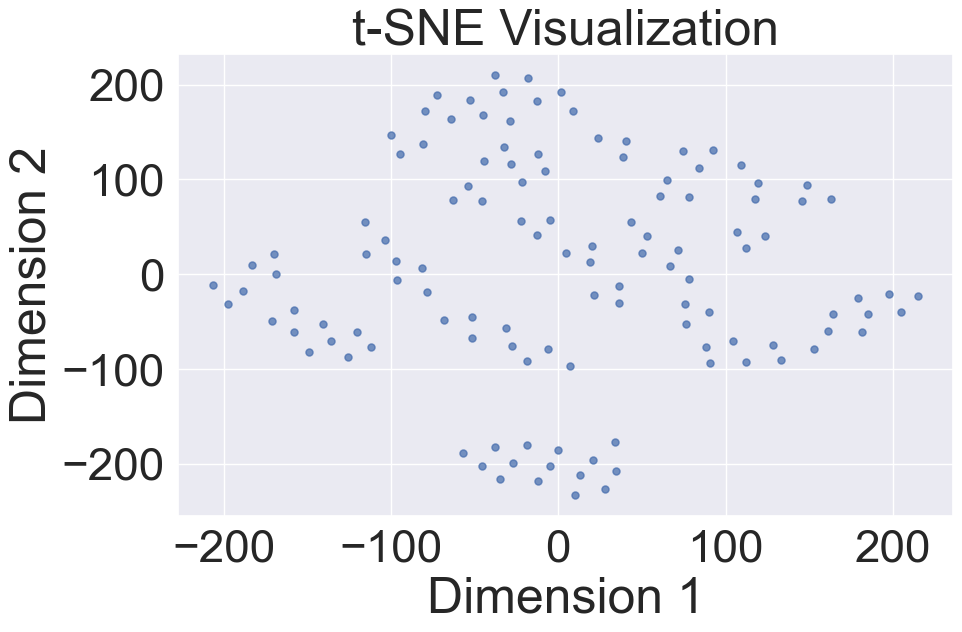

In [38]:
# Apply t-SNE to reduce the dimensionality to two dimensions
tsne = TSNE(n_components = 2, random_state = 42)
tsne_embeddings_2 = tsne.fit_transform(X_imp_2)

# Visualize the t-SNE embeddings
plt.figure(figsize=(10, 6))
plt.scatter(tsne_embeddings_2[:, 0], tsne_embeddings_2[:, 1], s=25, alpha=0.5)
plt.title('t-SNE Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


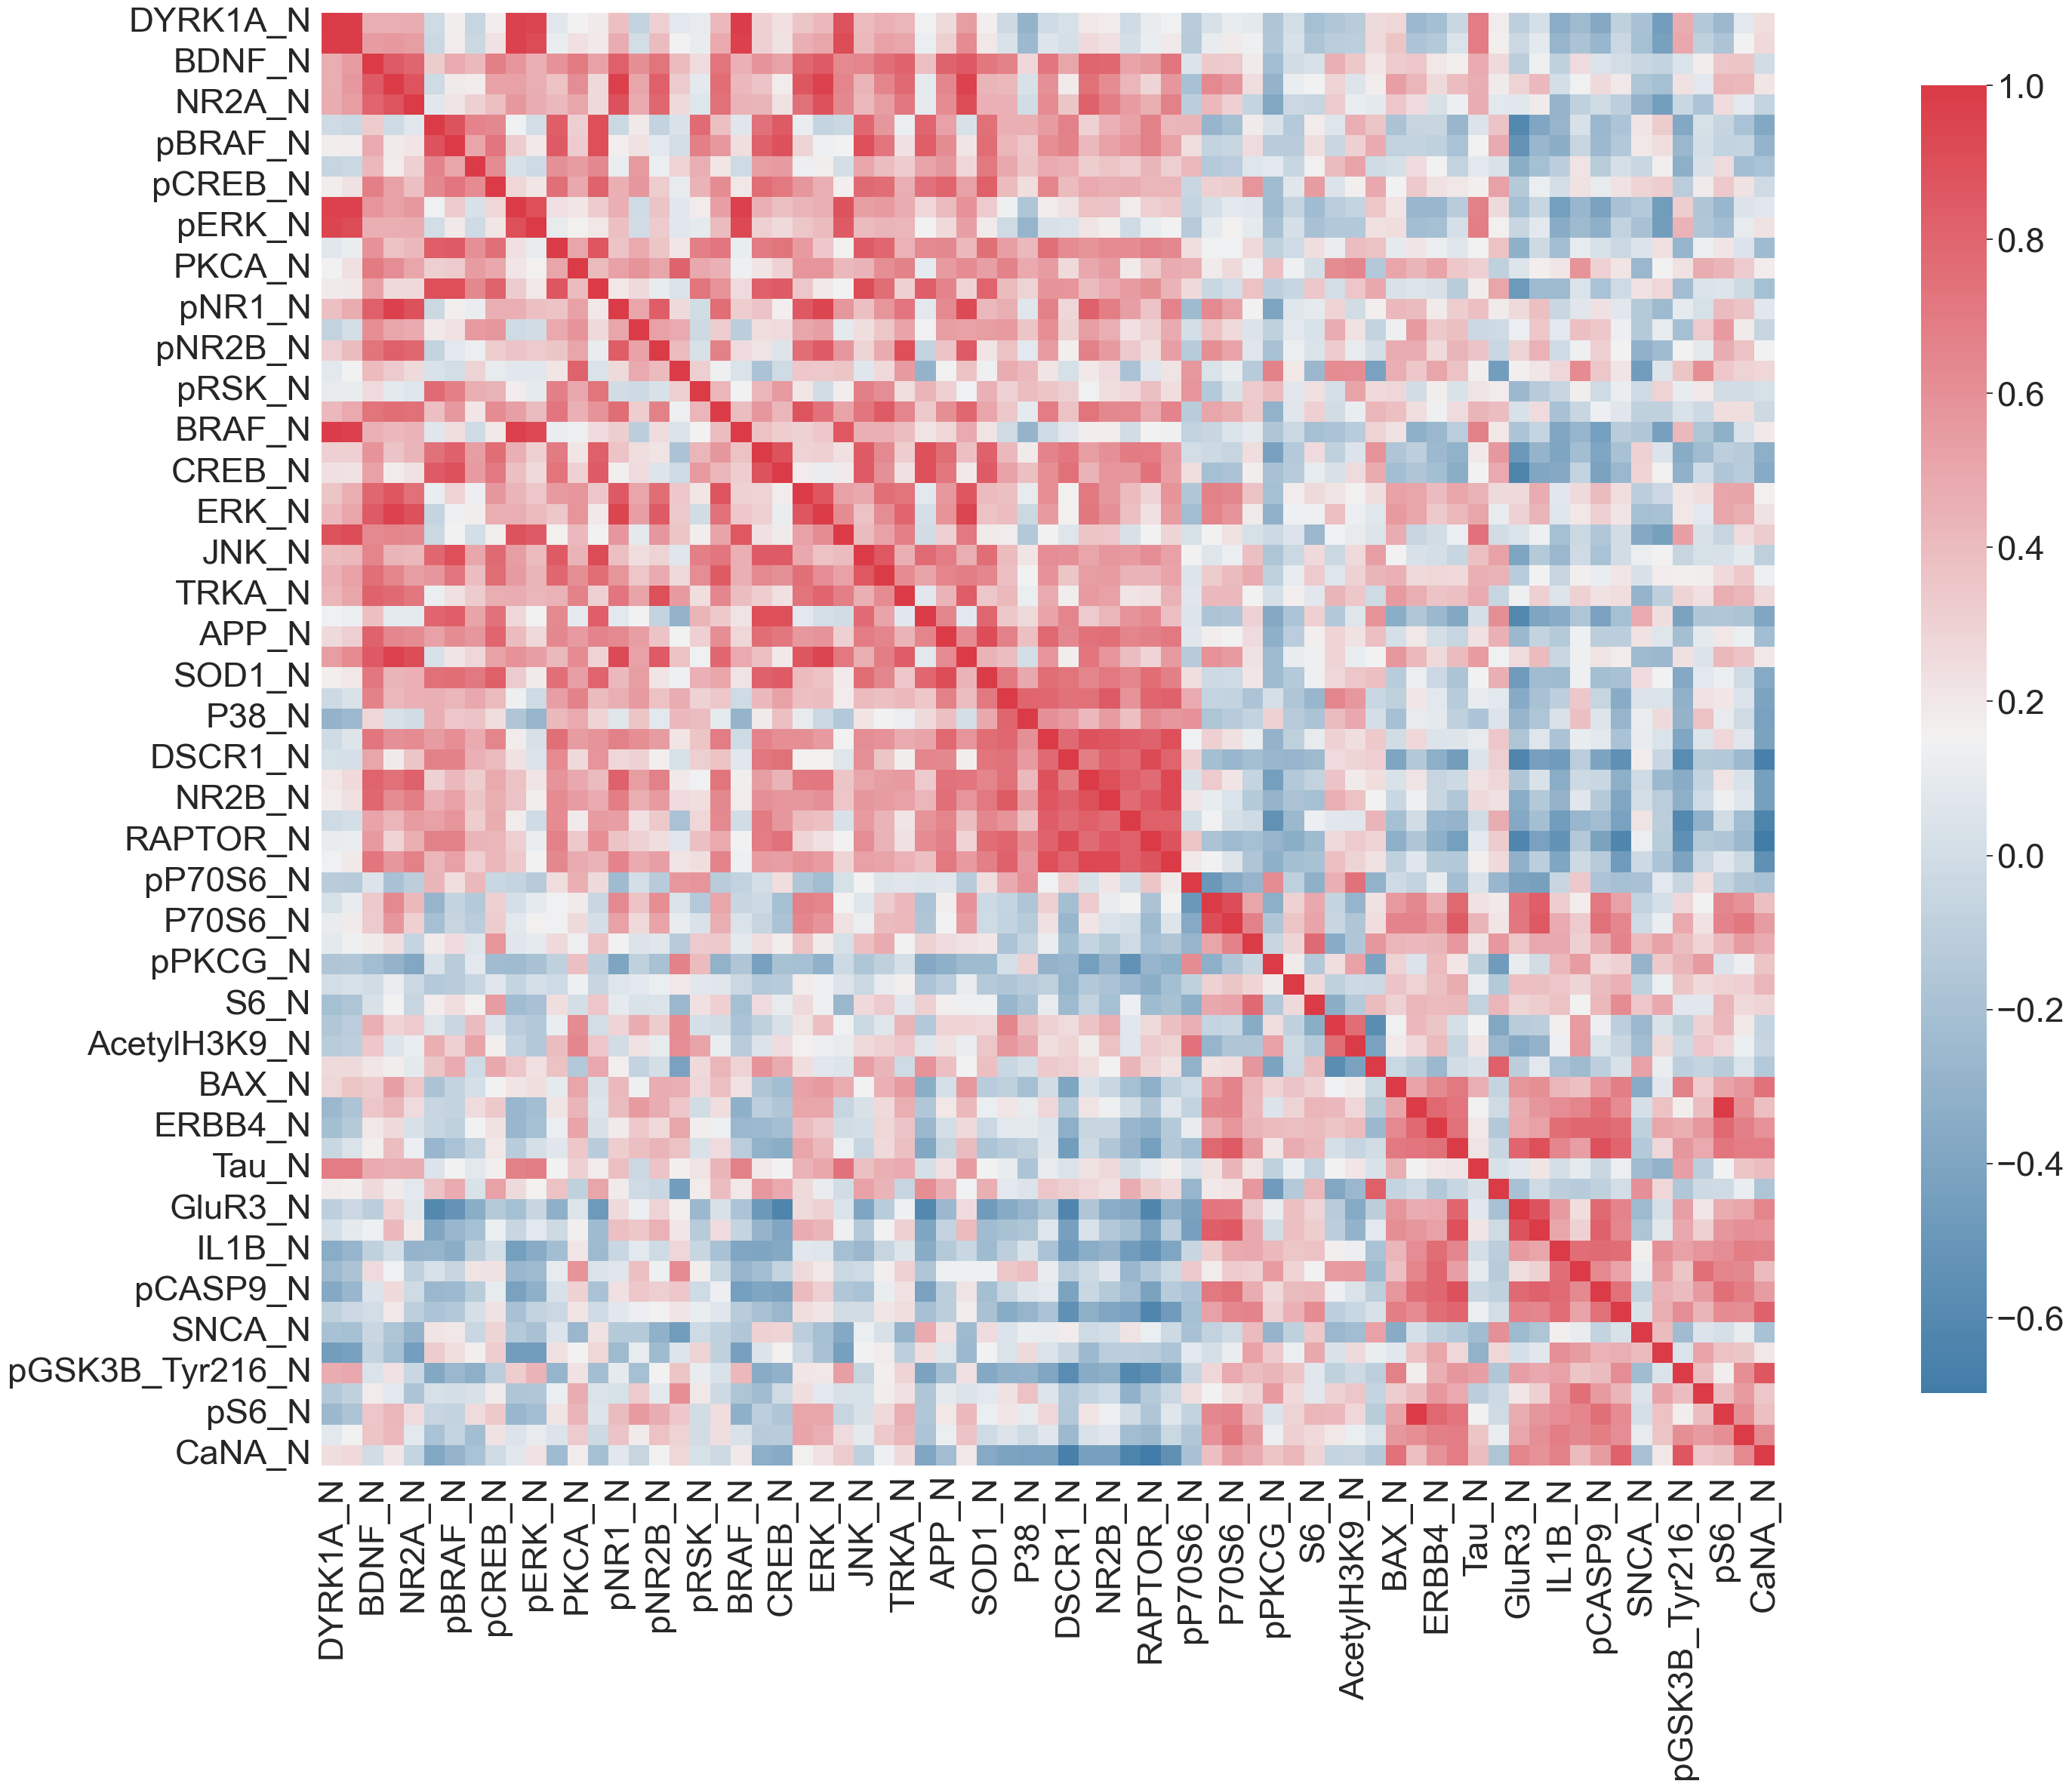

In [39]:
sns.set(font_scale = 3)   
plot_corr(X_imp_2)


In [40]:
# Extract features from your dataset
X_imp_3 = features[3]

# Define threshold for hierarchical clustering
threshold = 0.5

# Perform hierarchical clustering
Z_3, cluster_assignments_3 = hierarchical_clustering(X_imp_3, threshold)

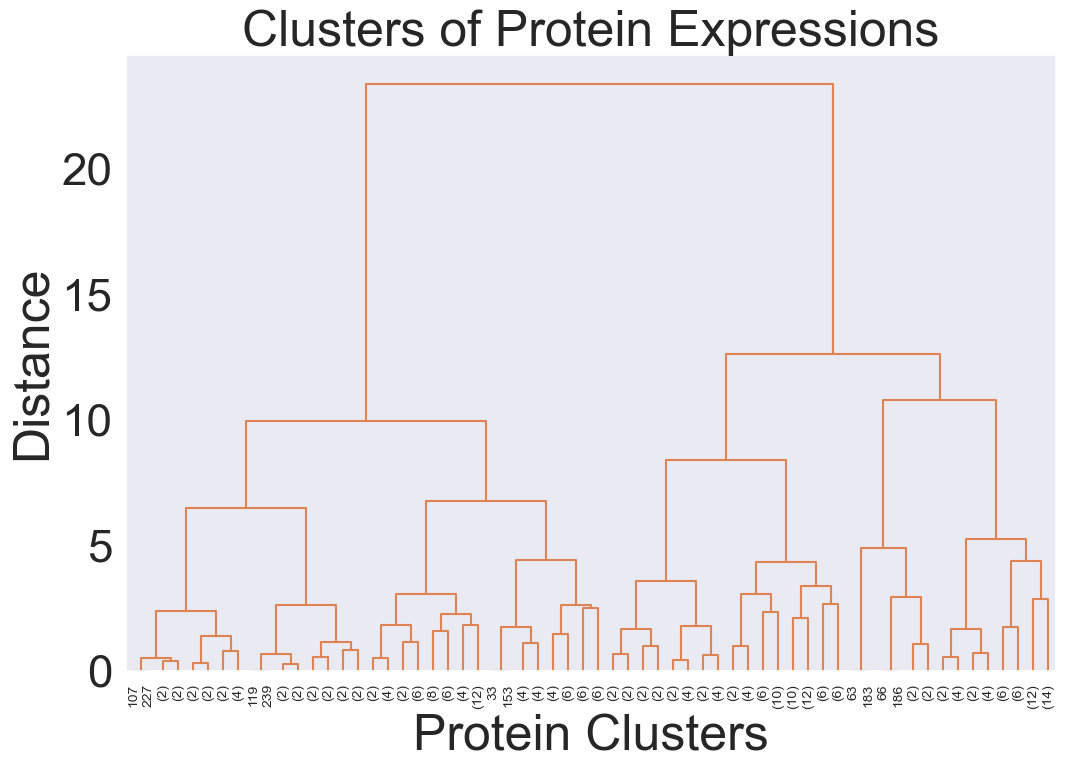

In [41]:
# Visualize the dendrogram with adjusted parameters
plt.figure(figsize=(12, 8))
dendrogram(Z_3, p = 5, truncate_mode = 'level', orientation='top', color_threshold=50, leaf_font_size=10)

plt.title('Clusters of Protein Expressions')
plt.xlabel('Protein Clusters')
plt.ylabel('Distance')
plt.grid(False)
plt.show()

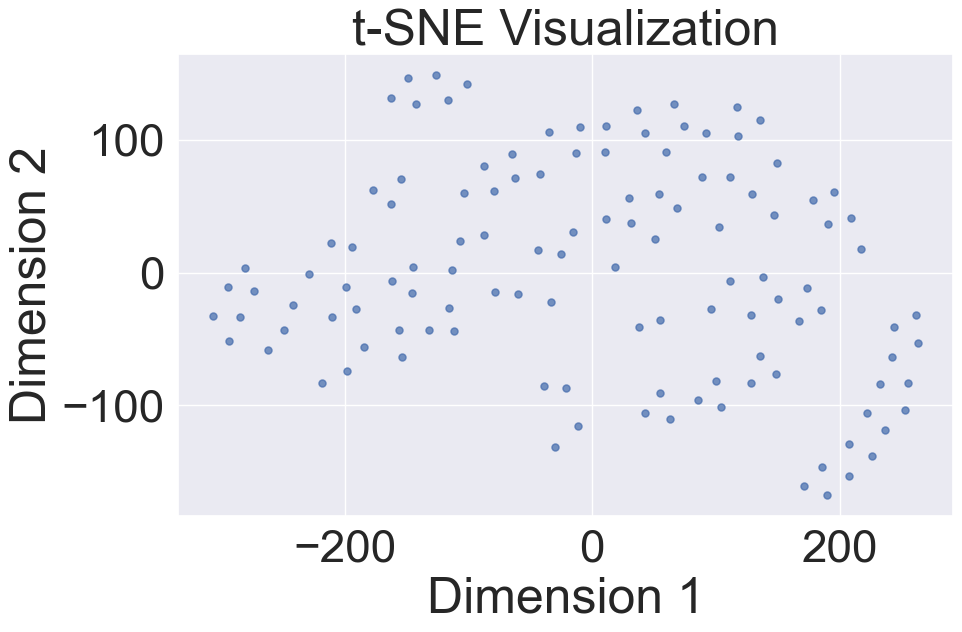

In [42]:
# Apply t-SNE to reduce the dimensionality to two dimensions
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings_3 = tsne.fit_transform(X_imp_3)

# Visualize the t-SNE embeddings
plt.figure(figsize=(10, 6))
plt.scatter(tsne_embeddings_3[:, 0], tsne_embeddings_3[:, 1], s=25, alpha=0.5)
plt.title('t-SNE Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


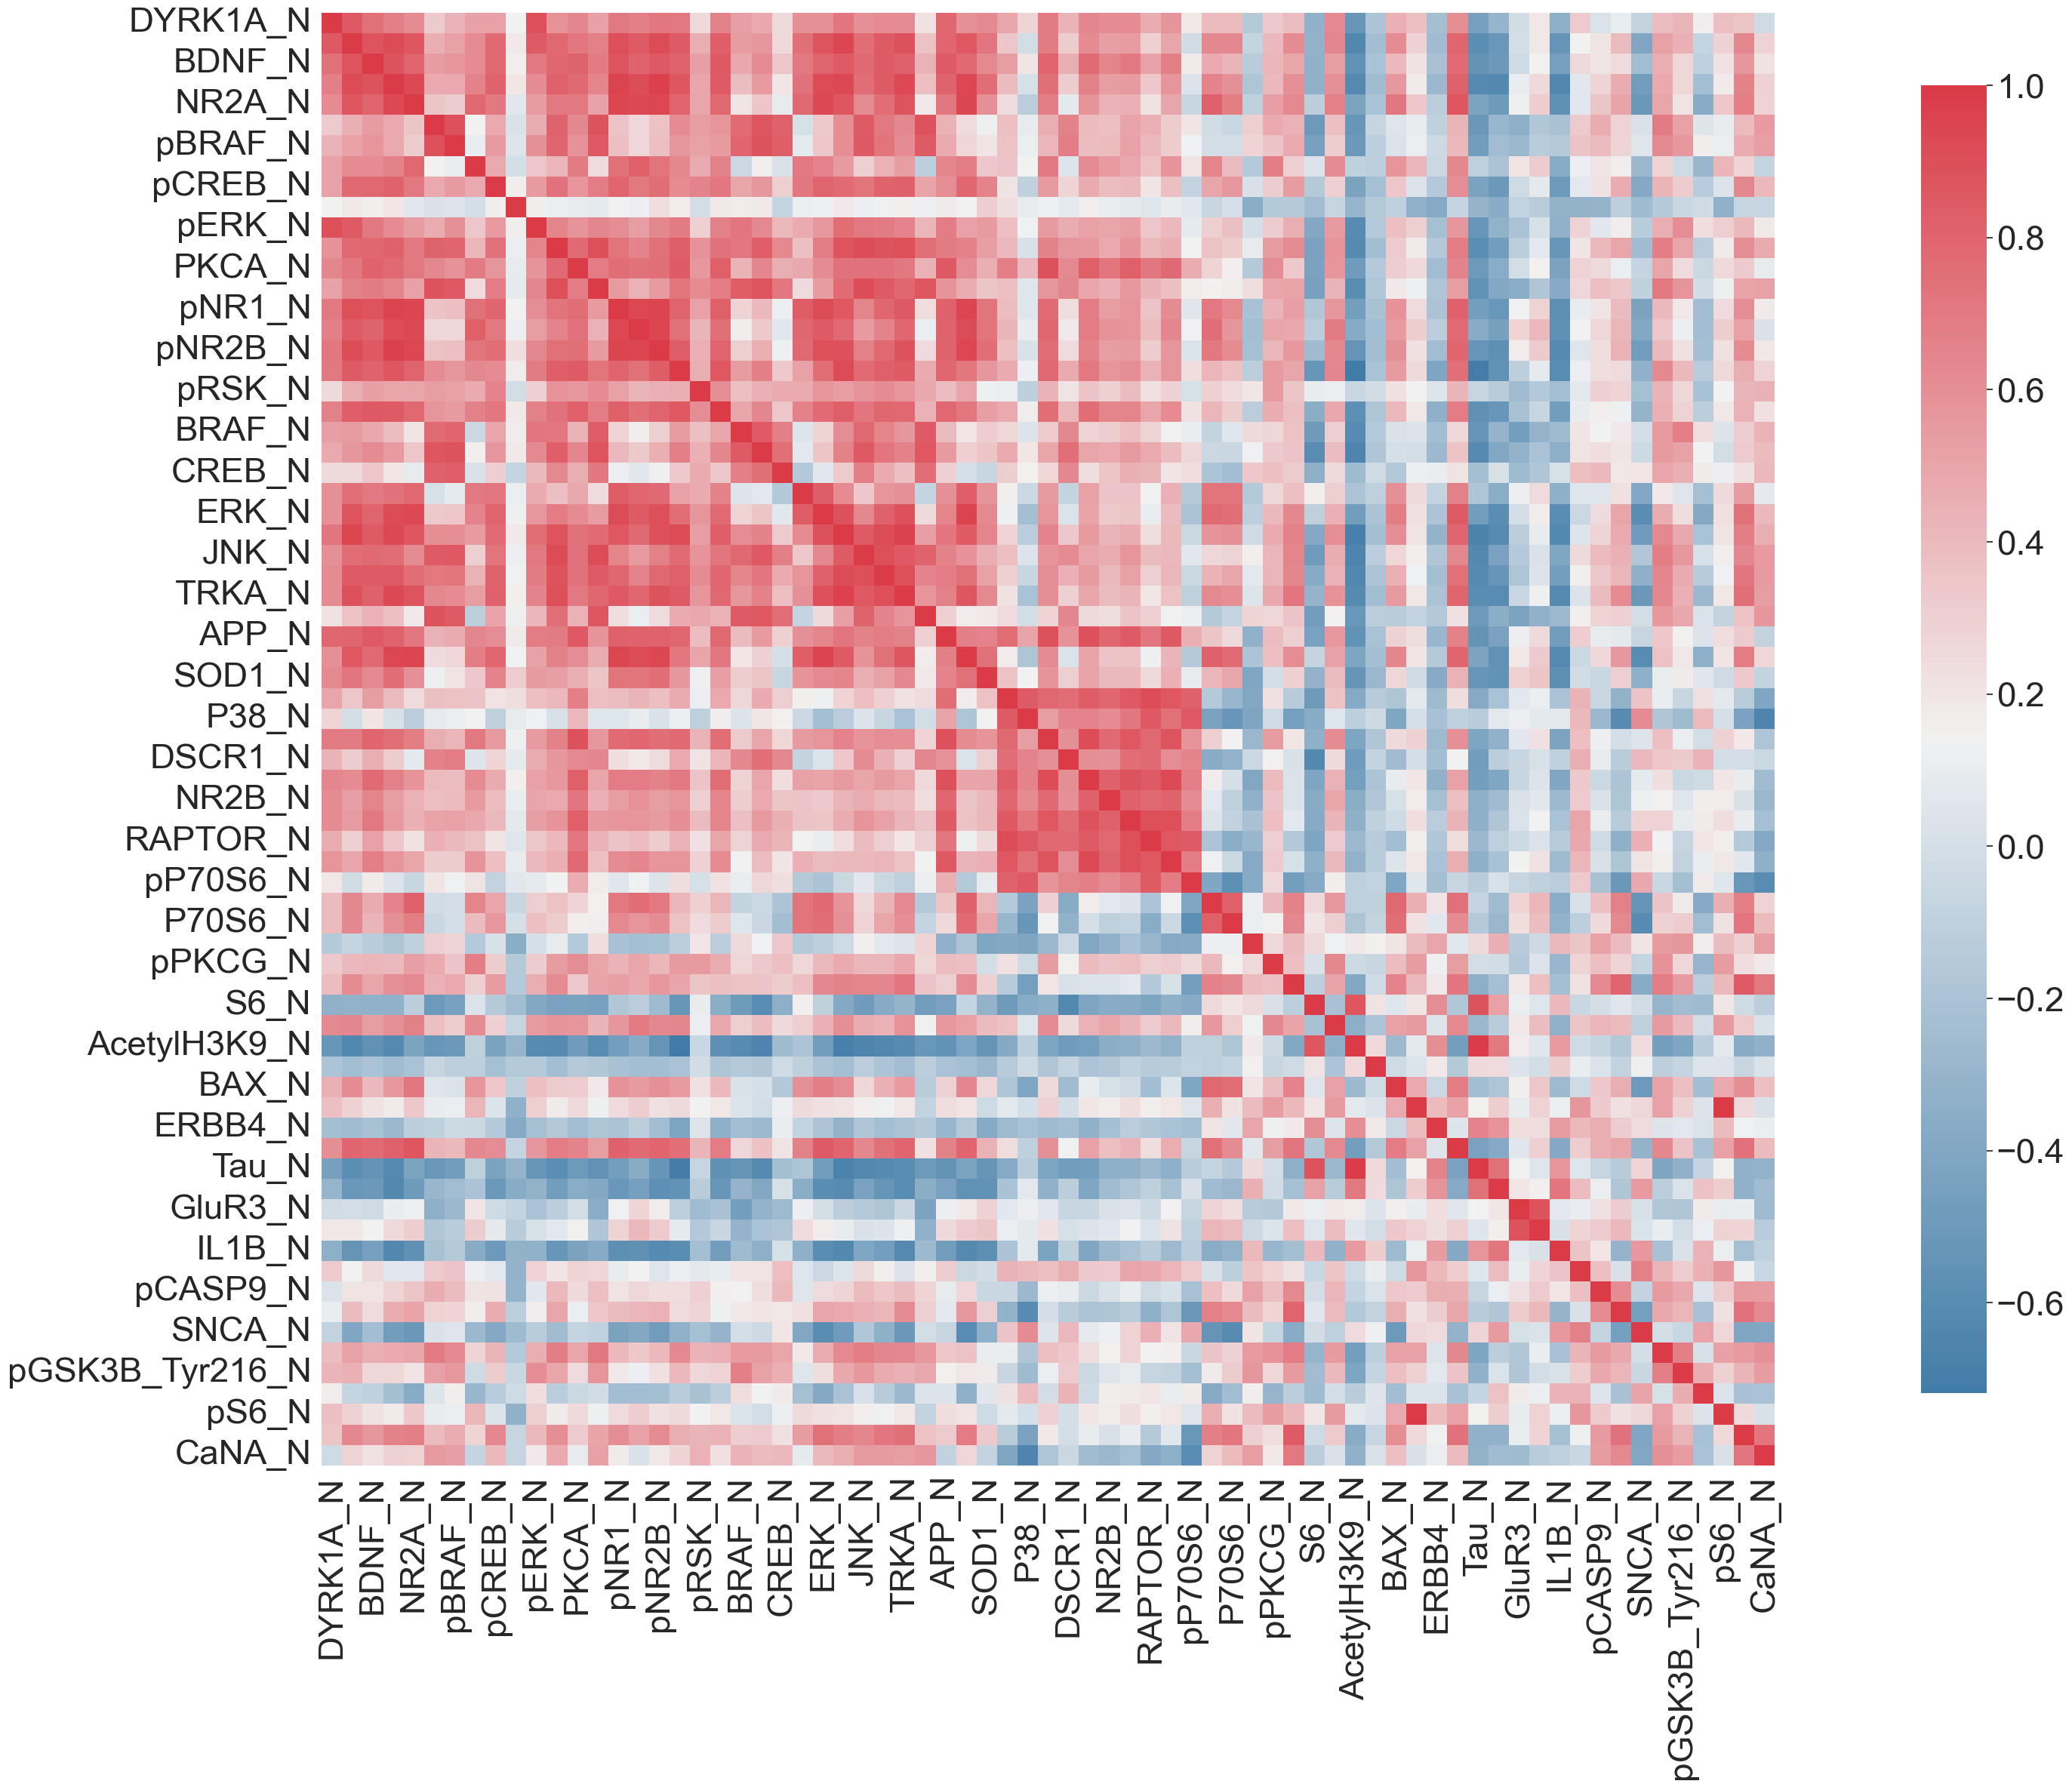

In [43]:
sns.set(font_scale = 3)   
plot_corr(X_imp_3)


## Finding ANOVA for each protein between each condition

In [67]:
# Looking at first 5 proteins being monitored
proteins = list(features[0].columns)
proteins[1:5]


['ITSN1_N', 'BDNF_N', 'NR1_N', 'NR2A_N']

In [45]:
# Looking at expression levels of each mouse for brain-derived neurotrophic factor proteins
protein_data = nmice['BDNF_N']
protein_data.head()


0    0.430175
1    0.411770
2    0.418309
3    0.358626
4    0.358802
Name: BDNF_N, dtype: float64

In [72]:
# Finding the ANOVA of each condition for every protein expression

conditions = nmice['class'].unique()

for pro in proteins:
    
    protein_data = nmice[[pro, 'class']]
    groups = []
    
    for condition in conditions:
        groups.append(protein_data[protein_data['class'] == condition][pro])
    
    f_statistic, p_value = f_oneway(*groups)
    print("Protein:", pro)
    print("F-statistic:", f_statistic)
    print("p-value:", p_value)
    
    if p_value < 0.05:
        print("Null Hypothesis = FALSE")
    else:
        print("Null Hypothesis = TRUE") 
    print('\n')


Protein: DYRK1A_N
F-statistic: 121.18959462723383
p-value: 1.3018734450020913e-149
Null Hypothesis = FALSE


Protein: ITSN1_N
F-statistic: 119.51455077475485
p-value: 8.269711767513665e-148
Null Hypothesis = FALSE


Protein: BDNF_N
F-statistic: 38.04863159894697
p-value: 1.7341923476378329e-50
Null Hypothesis = FALSE


Protein: NR1_N
F-statistic: 30.077840632892332
p-value: 7.684490661408082e-40
Null Hypothesis = FALSE


Protein: NR2A_N
F-statistic: 44.07892097132317
p-value: 2.0993089955065924e-58
Null Hypothesis = FALSE


Protein: pAKT_N
F-statistic: 67.67187719313497
p-value: 3.176110538875958e-88
Null Hypothesis = FALSE


Protein: pBRAF_N
F-statistic: 53.03485583285954
p-value: 6.124843788313485e-70
Null Hypothesis = FALSE


Protein: pCAMKII_N
F-statistic: 155.57401274468944
p-value: 3.887748325511446e-185
Null Hypothesis = FALSE


Protein: pCREB_N
F-statistic: 37.449588300505084
p-value: 1.0767691787494659e-49
Null Hypothesis = FALSE


Protein: pELK_N
F-statistic: 35.5667313946044

## Random Forest Classification

In [48]:
# Splitting the data into the target and features
X = nmice.loc[:, 'DYRK1A_N':'CaNA_N']
y = nmice['class']


In [49]:
# Splitting the train and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42)


In [50]:
#Creating a random forest classifier
clf = RandomForestClassifier(n_estimators = 100, random_state = 1, n_jobs = 1)

# Train the classifier
clf.fit(X_train, y_train)


RandomForestClassifier(n_jobs=1, random_state=1)

In [51]:
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)


0.9976133651551312

#### Finding important features from model

In [52]:
# assigning the all importance values to a series
importance = pd.Series(clf.feature_importances_)

# Print the name and gini importance of each feature
feat_list = []
for feature in zip(subset_cols, clf.feature_importances_):
    feat_list.append(feature)
    

In [53]:
sorted_feat_list = sorted(feat_list, key = lambda x: x[1], reverse = True)
sorted_feat_list[0:10]


[('SOD1_N', 0.058917464814705583),
 ('pPKCG_N', 0.044118504241221955),
 ('pERK_N', 0.042907218176640866),
 ('APP_N', 0.03725818677189515),
 ('CaNA_N', 0.030892705612382027),
 ('pCAMKII_N', 0.028830067239643997),
 ('DYRK1A_N', 0.028350519271057688),
 ('BRAF_N', 0.0265989407973531),
 ('ITSN1_N', 0.02637768318817465),
 ('pP70S6_N', 0.02616778599258011)]

### Random Forest Model for Important Features

#### Create a selector object that will use the random forest classifier to identify features that have an importance of more than 0.02

In [54]:
sfm = SelectFromModel(clf, threshold=0.02)

# Train the selector
sfm.fit(X_train, y_train)

# making arrays to keep track of the important proteins' importance values and index
imp = []
imp_index = []

# Print the names of the most important features
for feature_idx in sfm.get_support(indices = True):
    imp.append(list(subset_cols)[feature_idx])
    imp_index.append(feature_idx)

# Making the list of important proteins so I can make a dataframe with it
s_imp = pd.Series(imp)

# Getting the importance values of only the important proteins
protein_importance = importance[imp_index]

# Making a dataframe of the proteins with thei importance values
p = {'Important Proteins': imp, 'Importance Value': protein_importance}
df_importance = pd.DataFrame(p)


In [55]:
# sorting the proteins by importance and printing it
df_importance.sort_values('Importance Value', ascending = False, inplace = True)
print(df_importance)


   Important Proteins  Importance Value
32             SOD1_N          0.058917
46            pPKCG_N          0.044119
10             pERK_N          0.042907
30              APP_N          0.037258
70             CaNA_N          0.030893
7           pCAMKII_N          0.028830
0            DYRK1A_N          0.028351
20             BRAF_N          0.026599
1             ITSN1_N          0.026378
42           pP70S6_N          0.026168
65        Ubiquitin_N          0.024127
17           pPKCAB_N          0.022883
48               S6_N          0.022283
39            pNUMB_N          0.021976
68              pS6_N          0.021846
50       AcetylH3K9_N          0.020576
34              P38_N          0.020387


In [56]:
# creating new training sets
X_imp_train = sfm.transform(X_train)
X_imp_test = sfm.transform(X_test)


In [57]:
# creating a new random forest model classifier for the most important features
clf_imp = RandomForestClassifier(n_estimators = 100, random_state = 42)

# training the random forest classfier on the new limited feature data sets
clf_imp.fit(X_imp_train, y_train)


RandomForestClassifier(random_state=42)

In [58]:
# Test the classifer to get the accuracy
y_imp_pred = clf_imp.predict(X_imp_test)

# Getting the accuracy score of the limited classifier model
accuracy_score(y_test, y_imp_pred)


0.9952267303102625

## KMeans Clustering

In [59]:
# Perform KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(X)
cluster_centers = kmeans.cluster_centers_


/Users/jacobserfaty/opt/anaconda3/envs/new-learn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [60]:
# Add cluster labels as a new feature
X_clusters = np.hstack((X, cluster_labels.reshape(-1, 1)))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_clusters, y, test_size=0.3, random_state=42)

# Train a RandomForestClassifier
clf_kmean = RandomForestClassifier(random_state=42)
clf_kmean.fit(X_train, y_train)

# Predict on the test set
y_pred = clf_kmean.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 1.0


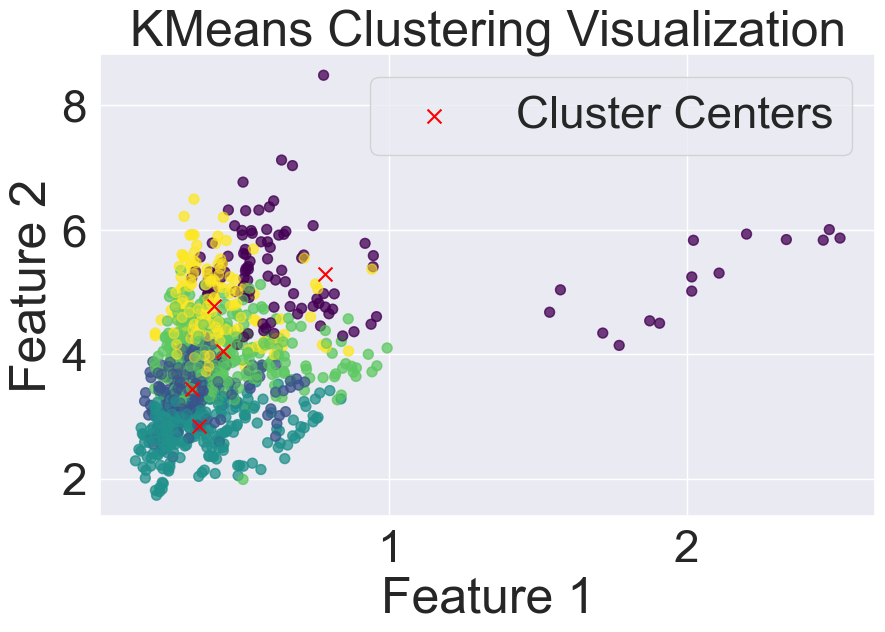

In [61]:
# Visualize the KMeans clusters
plt.figure(figsize = (10, 6))

# Plot data points colored by cluster labels
plt.scatter(X.iloc[:, 0], X.iloc[:, 4], c=cluster_labels, cmap='viridis', s=50, alpha=0.5)

# Plot cluster centers
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 4], c='red', marker='x', s=100, label='Cluster Centers')

plt.title('KMeans Clustering Visualization')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()
